### <span style="color:rgb(47,68,134)">Optimisation-RO</span>

### <span style="color:rgb(47,68,134)">Certification Chef de projet IA 2023-2024</span>


# <span style="color:rgb(47,68,134)">Notebook de la séance 4 - Régularisation</span>

Pour tout commentaire concernant ce notebook (y compris les typos), merci d'envoyer un mail à **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(47,68,134)">Introduction</span>

Ce notebook présente deux techniques de régularisation, et leur impact sur la résolution.

*Note : Si les différentes parties de ce notebook sont construites de sorte à être indépendantes, les blocs sont fait pour être exécutés de manière séquentielle. On prendra notamment soin d'exécuter le bloc ci-dessous (qui importe des bibliothèques et fonctions utiles) en premier.*

In [1]:
# Imports des bibliothèques et fonctions utiles
###############################################

# Affichage
%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Racine carrée

# NumPy - Structures vectorielles et matricielles
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Distributions de probabilités

# SciPy - Calculs mathématiques efficaces
from scipy.linalg import toeplitz # Matrice spéciales
from scipy.linalg import svdvals # Décomposition en valeurs singulières
from scipy.linalg import norm # Norme
from scipy.optimize import check_grad # Vérification des dérivées
from scipy.optimize import fmin_l_bfgs_b # Méthode de minimisation efficace

# <span style="color:rgb(47,68,134)">Partie 1 - Génération des données</span>

## <span style="color:rgb(47,68,134)">1.1 Données</span>

Soit un jeu de données $\{(\mathbf{a}_i,b_i)\}_{i=1,\dots,n}$, où $\mathbf{a}_i \in \mathbb{R}^d$ et $b_i \in \mathbb{R}$, que l'on met sous la forme

- d'une matrice de caractéristiques (features) $\mathbf{A} \in \mathbb{R}^{n \times d}$;
- et d'un vecteur de labels $\mathbf{b} \in \mathbb{R}^n$. 

Le jeu de données sera produit en utilisant la procédure ci-dessous, qui vise à générer des échantillons avec 
bruit et corrélation contrôlés.

In [2]:
# Ce code est bassé sur un générateur proposé par Alexandre Gramfort de l'INRIA.
def simu_lin(x, n, std=1., corr=0.5):
    """
    Génération de données issues d'un modèle linéaire.
    
    Paramètres
    ----------
    x : np.ndarray, shape=(d,)
        Coefficients du modèle
    
    n : int
        Taille de l'échantillon
    
    std : float, default=1.
        Ecart-type du bruit

    corr : float, default=0.5
        Corrélation de la matrice des caractéristiques
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

Les données seront ainsi produites à partir d'une tendance linéaire à laquelle on rajoutera un bruit gaussien.

## <span style="color:rgb(47,68,134)">1.2 Régression linéaire</span>

En *régression linéaire*, on s'intéresse à
$$
    \mbox{minimiser}_{\mathbf{x} \in \mathbb{R}^d} 
    f(\mathbf{x}) := \frac{1}{2 n} \|\mathbf{A} \mathbf{x} - \mathbf{b}\|^2 
    = \frac{1}{2n} \sum_{i=1}^n (\mathbf{a}_i^T \mathbf{x} - b_i)^2.
$$ 
Cette fonction est lisse, avec
$$
    \nabla f(\mathbf{x}) =\frac{1}{n}\mathbf{A}^T (\mathbf{A} \mathbf{x} - \mathbf{b}).
$$
et cette fonction est $L$-lipschitzienne avec $L=\frac{\|\mathbf{A}^T \mathbf{A}\|}{n}$.

## <span style="color:rgb(47,68,134)">1.3 Régression logistique</span>

En *régression logistique*, on considère un modèle linéaire avec une fonction de perte appropriée pour la classification binaire
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad 
    f_i(\mathbf{x})=\log(1+\exp(-b_i \mathbf{a}_i^T \mathbf{x})),
$$
où chaque $b_i$ est un label binaire de $\{-1,1\}$.

Chaque $f_i$ est une fonction lisse, avec notamment
$$
    \nabla f_i(\mathbf{x}) = - \frac{b_i}{1 + \exp(b_i \mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i.
$$
De plus, $f \in \mathcal{C}^{1,1}_L(\mathbb{R}^d)$ avec
$$
    L=\frac{\|\mathbf{A}^T \mathbf{A}\|}{4n}.
$$

## <span style="color:rgb(47,68,134)">1.4 Classes Python</span>

In [3]:
# Python class for regression problems
class RegressionPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            X: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of X
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
    '''
   
    # Instantiate the class
    def __init__(self, X, y,loss='l2'):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.loss = loss
        
    
    # Objective value
    def fun(self, w):
        if self.loss=='l2':
            return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) 
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            return np.mean(np.log(1. + np.exp(-yXw))) 
    
    # Full gradient computation
    def grad(self, w):
        if self.loss=='l2':
            return self.X.T.dot(self.X.dot(w) - self.y) / self.n
        elif self.loss=='logit':
            yXw = self.y * self.X.dot(w)
            aux = 1. / (1. + np.exp(yXw))
            return - (self.X.T).dot(self.y * aux) / self.n 

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.X, ord=2) ** 2 / self.n 
        elif self.loss=='logit':
            L = norm(self.X, ord=2) ** 2 / (4. * self.n) 
        return L
    
    # ''Strong'' convexity constant (could be zero)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.X)
            mu = min(s)**2 / self.n 
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

In [5]:
# Génération des instances

# d = 50
d = 16
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Générateur de nombres aléatoires fixé
np.random.seed(0)

# Vérité terrain
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

Xlin, ylin = simu_lin(w_model_truth, n, std=1., corr=0.1)
Xlog, ylog = simu_lin(w_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Logarithme pour la classification binaire

pblinreg = RegressionPb(Xlin, ylin,loss='l2')
pblogreg = RegressionPb(Xlog, ylog,loss='logit')

In [6]:
# Use L-BFGS-B to determine a solution for both problems

w_init = np.zeros(d)
# Calcul d'une solution quasi-optimale pour la régression linéaire
w_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, w_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(w_min_lin)))
# Calcul d'une solution quasi-optimale pour la régression logistique
w_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, w_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)

print(f_min_log)
print(norm(pblogreg.grad(w_min_log)))

0.4725999960108297
1.8272355488683537e-09
0.4834786386938971
1.7188257155776676e-09


# <span style="color:rgb(47,68,134)">Partie 2 - Regularisation en norme $\ell_2$</span>

## <span style="color:rgb(47,68,134)">2.1 Régression linéaire avec régularisation $\ell_2$</span>

On s'intéresse ici au problème de *régression écrêtée* (ridge regression)
$$
    \mathrm{minimize}_{x \in \mathbb{R}^d} f_{\ell_2}(\mathbf{x}) = \frac{1}{2n} \|\mathbf{A} \mathbf{x} - \mathbf{b}\|^2 + \frac{\lambda}{2} \|\mathbf{x}\|^2,
$$
commonly called *ridge regression* problem.

La fonction $f_{\ell_2}$ est lisse. Son gradient est en particulier égal à
$$
\nabla f_{\ell_2}(\mathbf{x}) = \tfrac{\mathbf{A}^T \mathbf{A}+ \lambda n \mathbf{I}}{n} \mathbf{x} -\mathbf{A}^T \mathbf{b}. 
$$
et il s'agit d'une fonction $(L+\lambda)$-lipschitzienne.

In the context of linear regression $\ell_2$ regularization can be interpreted in several ways:

1) In terms of linear algebra: Regularizing the optimality conditions linear system $\mathbf{X}^T \mathbf{X} \mathbf{w} = \mathbf{X}^T \mathbf{y}$ into another system with a unique solution for $\lambda>0$.

2) In terms of optimization: The regularized optimization problem is strongly convex (and continuous), hence it possesses a single global minimum.

3) As $\lambda \rightarrow \infty$, the regularization term reduces the dependency of the solution to the data, and, consequently, its variance with respect to the data.

4) Implicitly, this regularization enforces a constraint on the $\ell_2$ norm of the solution.

## <span style="color:rgb(47,68,134)">2.2 Descente de gradient avec régularisation $\ell_2$</span>

Le code ci-dessous (en anglais) est une modification simple de la descente de gradient qui prend en compte un terme modulable de régularisation $\ell_2$.

In [7]:
# Implementation of gradient descent
def gd_l2(w0,problem,lbda,wtarget,stepchoice=0,step0=1, n_iter=1000, verbose=False): 
    """
        A code for gradient descent for problems with l2 regularization.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(w) evaluates the objective function at a given vector w
                problem.grad(w) evaluates the gradient of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
            lbda: Regularization parameter
            wtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize (see above)
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            verbose: Boolean value indicating whether the outcome of every iteration should be displayed
      
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a NumPy array of length at most n_iter)
            normits: History of distances between iterates and optimum (NumPy array of length at most n_iter)
            normgrads: History of gradient norms (output as NumPy array of length at most n_iter)
            
    """
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # gradient norms
    normgrads = []
    
    # Lipschitz constant for the regularized problem
    L = problem.lipgrad() + lbda
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(w)  + lbda* norm(w) ** 2 / 2.
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(w-wtarget)
    normits.append(nmin)
    # Current gradient norm
    g = problem.grad(w) + lbda * w
    ng = norm(g)
    normgrads.append(ng)

    # Plot the initial values if required
    if verbose:
        print("Gradient Descent:")
        print(' | '.join([name.center(8) for name in ["iter", "fval", "dist","ngrad"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))
    
    ####################
    # Main loop
    while (k < n_iter):

        # Select the stepsize and perform the update
        if stepchoice==0:
            w[:] = w - (1/L) * g
        elif stepchoice==1:
            w[:] = w - (step0/(k+1))*g
        else:
            w[:] = w - (step0/(sqrt(k+1)))*g
        
        # Compute and plot the new objective value and distance to the minimum
        obj = problem.fun(w) + lbda * norm(w)**2 /2.
        objvals.append(obj)
        nmin = norm(w-wtarget)
        normits.append(nmin)
        # Compute the gradient
        g = problem.grad(w) + lbda * w
        ng = norm(g)
        normgrads.append(ng)
        
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8),("%.2e" % ng).rjust(8)]))       
        
        # Increment the iteration count
        k += 1
    
    # End main loop
    ######################
    
    # Output
    w_output = w.copy()
    return w_output, np.array(objvals), np.array(normits), np.array(normgrads)

On affiche ensuite la valeur souhaitée pour différentes valeurs de régularisation.

Norme au carré avec lbda=0: 5.473684747745738
Norme au carré avec lbda=0.1: 4.417355648045578
Norme au carré avec lbda=1: 1.2180113657665197
Norme au carré avec lbda=10: 0.037467142954638204
Norme au carré avec lbda=100: 0.00043910836405447646


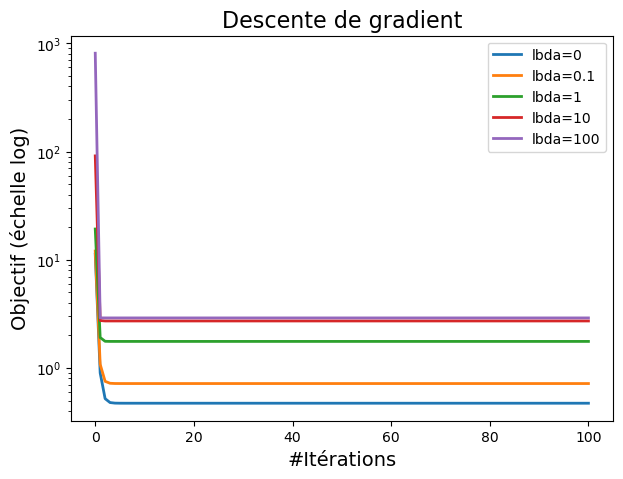

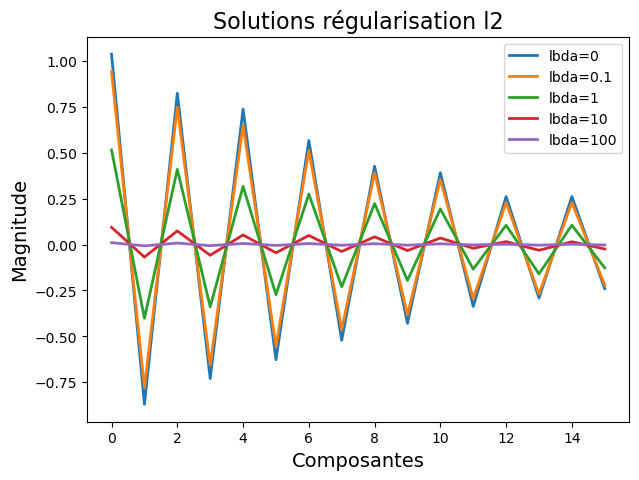

In [8]:
# Test régularisation l2
lvals = [0,0.1,1,10,100]
nlbda = len(lvals)
lbda = 100
w0 = np.ones(d)
Wsol = np.zeros((d,nlbda))

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    lbda =lvals[i]
    Wsol[:,i], obj_gd, _,_ = gd_l2(w0,pblinreg,lbda,w_min_lin,stepchoice=0,step0=1, n_iter=100)
    print("Norme au carré avec lbda="+str(lbda)+": "+str(norm(Wsol[:,i])**2))
    plt.semilogy(obj_gd, label="lbda="+str(lbda), lw=2)
plt.title("Descente de gradient", fontsize=16)
plt.xlabel("#Itérations", fontsize=14)
plt.ylabel("Objectif (échelle log)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(Wsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("Solutions régularisation l2", fontsize=16)
plt.xlabel("Composantes", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

La norme $\ell_2$ lisse la solution et conduit à des solutions avec normes de plus en plus faibles, mais dont les composantes se réduisent de manière uniforme.

# <span style="color:rgb(47,68,134)">Partie 3 - Régularisation en norme $\ell_1$</span>

## <span style="color:rgb(47,68,134)">3.1 Régression logistique avec régularisation $\ell_1$</span>

On considère maintenant le problème de régression logistique avec régularisation $\ell_1$ 
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f_{\ell_1}(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}) + \lambda \|\mathbf{x}\|_1,
$$
where $f_i(\mathbf{x})=\log(1+\exp(-b_i \mathbf{a}_i^T \mathbf{x}))$, $\lambda \ge 0$, and $\|\mathbf{x}\|_1 = \sum_{i=1}^n \left|x_i\right|$.

La fonction $f_{\ell_1}$ n'est pas lisse à cause du terme en norme $\ell_1$.

## <span style="color:rgb(47,68,134)">3.2 Algorithme ISTA pour la régression $\ell_1$</span>

On rappelle ici le principe de l'algorithme *Iterative Soft-Thresholding Algorithm* (ISTA).

Partant d'un itéré $\mathbf{x}_k$ et d'une longueur de pas $\alpha_k$, on calcule d'abord
$$
    \mathbf{g}_k = \mathbf{x}_k - \alpha_k \nabla f(\mathbf{x}_k),
$$
où $f$ représente la partie lisse de
$f_{\ell_1}(\mathbf{x}) = f(\mathbf{x}) + \lambda \|\mathbf{x}\|_1$.

On obtient ensuite $\mathbf{x}_{k+1}$ par la formule suivante
$$
    \forall i=1,\dots,d, \quad [\mathbf{x}_{k+1}]_i \; = \; 
    \left\{
        \begin{array}{ll}
            [\mathbf{g}_k]_i + \lambda \alpha_k &\mathrm{si} [\mathbf{g}_k]_i < -\lambda \alpha_k \\
            [\mathbf{g}_k]_i - \lambda \alpha_k &\mathrm{si} [\mathbf{g}_k]_i > \lambda \alpha_k \\
            0 &\mathrm{sinon.}
        \end{array}
    \right.
$$

Le code ci-dessous (en anglais) implémente l'algorihme ISTA.

In [9]:
# Implementation of ISTA
def ista(w0,problem,lbda,stepchoice=0,step0=1, n_iter=1000,verbose=False): 
    """
        A code for ISTA with various step choices.
        
        Inputs:
            w0: Initial vector
            problem: Problem structure
                problem.fun(w) evaluates the objective function (which is assumed to be a finite sum of functions) at a given vector w
                problem.n returns the number of components in the finite sum
                problem.grad(w) evaluates the gradient of the smooth part of the objective function at a vector w
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
            lbda: Regularization parameter
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                1: Step size decreasing in 1/(k+1)
                2: Step size decreasing in 1/sqrt(k+1)
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations
            
        Outputs:
            w_output: Final iterate of the method
            objvals: History of function values (output as a Numpy array of length n_iter at most)
    """   
    
    
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Initial value of current iterate   
    w = w0.copy()

    # Initialize iteration counter
    k=0    
    
    # Current objective
    obj = problem.fun(w) 
    objvals.append(obj);

    step=step0 # Initialize constant stepsize
    threshold=0 # Initialize threshold for proximal step
    
    # Display initial quantities
    if verbose:
        print("ISTA:")
        print(' | '.join([name.center(8) for name in ["iter", "fval"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))
    
    
    ##########################
    # Main loop
    while (k < n_iter):
        # Compute the gradient of the smooth part
        g = problem.grad(w)
        # Select the stepsize
        if stepchoice==0:
            step = 1/L
        elif (stepchoice==1):
            step = step0/(k+1)
        else:
            step = step0/(sqrt(k+1))
        
        # Compute the proximal gradient step
        for i in range(problem.d):
            vali = w[i]-step*g[i]
            threshold = step*lbda
            if vali < -threshold:
                w[i] = vali+threshold
            elif vali > threshold:
                w[i] = vali-threshold
            else:
                w[i] = 0
            
        # Update objective value and iteration index
        obj = problem.fun(w)
        objvals.append(obj);
        k += 1
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8)]))       
        
    # Output 
    w_output = w.copy()
          
    return w_output, np.array(objvals)

On compare l'exécution d'ISTA pour différentes valeurs du paramètre de régularisation :
$$
    \left\{0,\frac{1}{n},\frac{1}{n^{3/4}},\frac{1}{n^{2/3}}, \frac{1}{n^{1/2}}, \frac{1}{n^{1/3}}\right\}.
$$

Coefficients non nuls avec lbda=0: 16
Coefficients non nuls avec lbda=0.001: 16
Coefficients non nuls avec lbda=0.005623413251903491: 16
Coefficients non nuls avec lbda=0.010000000000000004: 14
Coefficients non nuls avec lbda=0.03162277660168379: 6
Coefficients non nuls avec lbda=0.10000000000000002: 1


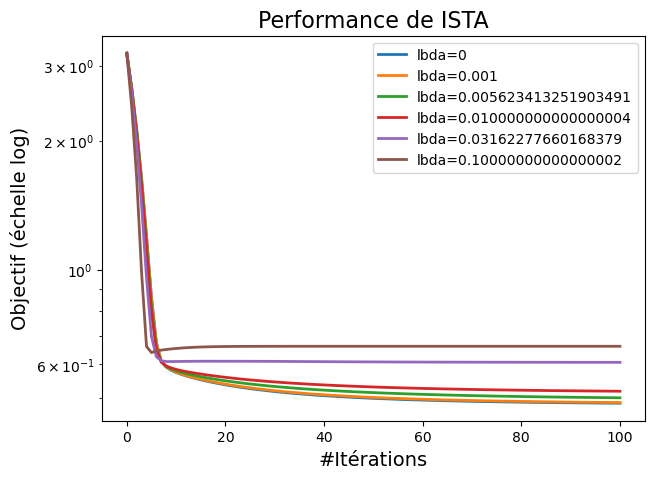

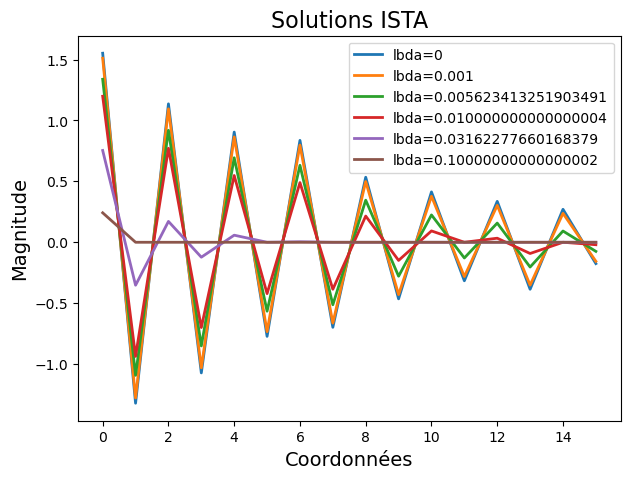

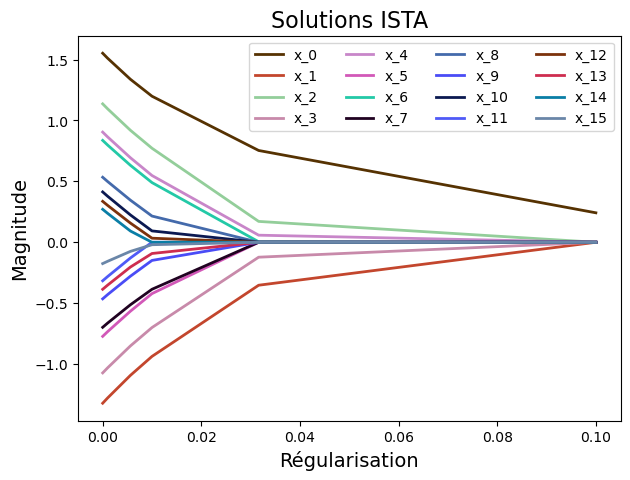

In [10]:
# Test regularisation l1
lvals = [0,1./n,1./(n**(3/4)),1./(n**(2/3)),1./(n**(1/2)),1./(n**(1/3))]
nlbda = len(lvals)
lbda = 100
w0 = np.ones(d)
Wsol = np.zeros((d,nlbda))

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    lbda =lvals[i]
    Wsol[:,i], obj_is = ista(w0,pblogreg,lbda,stepchoice=0,step0=1, n_iter=100)
    print("Coefficients non nuls avec lbda="+str(lbda)+": "+str(np.count_nonzero(Wsol[:,i])))
    plt.semilogy(obj_is, label="lbda="+str(lbda), lw=2)
plt.title("Performance de ISTA", fontsize=16)
plt.xlabel("#Itérations", fontsize=14)
plt.ylabel("Objectif (échelle log)", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(nlbda):
    plt.plot(Wsol[:,i],label="lbda="+str(lvals[i]), lw=2)
plt.title("Solutions ISTA", fontsize=16)
plt.xlabel("Coordonnées", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(loc=1)

plt.figure(figsize=(7, 5))
for i in range(d):
    plt.plot(lvals,Wsol[i,:],label="x_"+str(i),c=np.random.rand(3,), lw=2)
plt.title("Solutions ISTA", fontsize=16)
plt.xlabel("Régularisation", fontsize=14)
plt.ylabel("Magnitude", fontsize=14)
plt.legend(ncol=4,loc=1)

Ces résultats confirment que la régularisation $\ell_1$ conduit à des solutions de plus en plus parcimonieuses (au fur et à mesure que la régularisation augmente, le nombre de composantes nulles diminue).

In [ ]:
# Version 3.0 - C. W. Royer, Octobre 2023.